In [1]:
import os

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from collections import OrderedDict
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import numpy as np

from PIL import Image
from matplotlib import cm

In [2]:
BN_MOMENTUM = 0.1

body_point_names = ["R_ANKLE", "R_KNEE", "R_HIP", "L_HIP", "L_KNEE", "L_ANKLE", "PELVIS", "THORAX", "UPPER_NECK", "HEAD_TOP", "R_WRIST", "R_ELBOW", "R_SHOULDER", "L_SHOULDER", "L_ELBOW", "L_WRIST"]
# data_path = '../../data/pose_estimator/images'
data_path = '../../data/pose_estimator/test_img'

In [3]:
POSE_RESNET = edict()
POSE_RESNET.NUM_LAYERS = 50
POSE_RESNET.DECONV_WITH_BIAS = False
POSE_RESNET.NUM_DECONV_LAYERS = 3
POSE_RESNET.NUM_DECONV_FILTERS = [256, 256, 256]
POSE_RESNET.NUM_DECONV_KERNELS = [4, 4, 4]
POSE_RESNET.FINAL_CONV_KERNEL = 1
POSE_RESNET.TARGET_TYPE = 'gaussian'
POSE_RESNET.HEATMAP_SIZE = [64, 64]  # width * height, ex: 24 * 32
POSE_RESNET.SIGMA = 2

In [6]:
# common params for NETWORK
cfg = edict()
cfg.MODEL = edict()
cfg.MODEL.NAME = 'pose_resnet'
cfg.MODEL.INIT_WEIGHTS = True
cfg.MODEL.PRETRAINED = ''
cfg.MODEL.NUM_JOINTS = 16
cfg.MODEL.IMAGE_SIZE = [256, 256]  # width * height, ex: 192 * 256
cfg.MODEL.EXTRA = POSE_RESNET

In [10]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                                  momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [11]:
class PoseResNet(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 64
        extra = POSE_RESNET
        self.deconv_with_bias = extra.DECONV_WITH_BIAS

        super(PoseResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # used for deconv layers
        self.deconv_layers = self._make_deconv_layer(
            extra.NUM_DECONV_LAYERS,
            extra.NUM_DECONV_FILTERS,
            extra.NUM_DECONV_KERNELS,
        )

        self.final_layer = nn.Conv2d(
            in_channels=extra.NUM_DECONV_FILTERS[-1],
            out_channels=cfg.MODEL.NUM_JOINTS,
            kernel_size=extra.FINAL_CONV_KERNEL,
            stride=1,
            padding=1 if extra.FINAL_CONV_KERNEL == 3 else 0
        )

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _get_deconv_cfg(self, deconv_kernel, index):
        if deconv_kernel == 4:
            padding = 1
            output_padding = 0
        elif deconv_kernel == 3:
            padding = 1
            output_padding = 1
        elif deconv_kernel == 2:
            padding = 0
            output_padding = 0

        return deconv_kernel, padding, output_padding

    def _make_deconv_layer(self, num_layers, num_filters, num_kernels):
        assert num_layers == len(num_filters), \
            'ERROR: num_deconv_layers is different len(num_deconv_filters)'
        assert num_layers == len(num_kernels), \
            'ERROR: num_deconv_layers is different len(num_deconv_filters)'

        layers = []
        for i in range(num_layers):
            kernel, padding, output_padding = \
                self._get_deconv_cfg(num_kernels[i], i)

            planes = num_filters[i]
            layers.append(
                nn.ConvTranspose2d(
                    in_channels=self.inplanes,
                    out_channels=planes,
                    kernel_size=kernel,
                    stride=2,
                    padding=padding,
                    output_padding=output_padding,
                    bias=self.deconv_with_bias))
            layers.append(nn.BatchNorm2d(planes, momentum=BN_MOMENTUM))
            layers.append(nn.ReLU(inplace=True))
            self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.deconv_layers(x)
        x = self.final_layer(x)

        return x

    def init_weights(self, pretrained=''):
        if os.path.isfile(pretrained):
            logger.info('=> init deconv weights from normal distribution')
            for name, m in self.deconv_layers.named_modules():
                if isinstance(m, nn.ConvTranspose2d):
                    logger.info('=> init {}.weight as normal(0, 0.001)'.format(name))
                    logger.info('=> init {}.bias as 0'.format(name))
                    nn.init.normal_(m.weight, std=0.001)
                    if self.deconv_with_bias:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    logger.info('=> init {}.weight as 1'.format(name))
                    logger.info('=> init {}.bias as 0'.format(name))
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
            logger.info('=> init final conv weights from normal distribution')
            for m in self.final_layer.modules():
                if isinstance(m, nn.Conv2d):
                    # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    logger.info('=> init {}.weight as normal(0, 0.001)'.format(name))
                    logger.info('=> init {}.bias as 0'.format(name))
                    nn.init.normal_(m.weight, std=0.001)
                    nn.init.constant_(m.bias, 0)

            # pretrained_state_dict = torch.load(pretrained)
            logger.info('=> loading pretrained model {}'.format(pretrained))
            # self.load_state_dict(pretrained_state_dict, strict=False)
            checkpoint = torch.load(pretrained)
            if isinstance(checkpoint, OrderedDict):
                state_dict = checkpoint
            elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
                state_dict_old = checkpoint['state_dict']
                state_dict = OrderedDict()
                # delete 'module.' because it is saved from DataParallel module
                for key in state_dict_old.keys():
                    if key.startswith('module.'):
                        # state_dict[key[7:]] = state_dict[key]
                        # state_dict.pop(key)
                        state_dict[key[7:]] = state_dict_old[key]
                    else:
                        state_dict[key] = state_dict_old[key]
            else:
                raise RuntimeError(
                    'No state_dict found in checkpoint file {}'.format(pretrained))
            self.load_state_dict(state_dict, strict=False)
        else:
            logger.error('=> imagenet pretrained model dose not exist')
            logger.error('=> please download it first')
            raise ValueError('imagenet pretrained model does not exist')

In [13]:
resnet_spec = {50: (Bottleneck, [3, 4, 6, 3]),
               101: (Bottleneck, [3, 4, 23, 3]),
               152: (Bottleneck, [3, 8, 36, 3])}


def get_pose_net(num_layers, is_train):
    block_class, layers = resnet_spec[num_layers]
    model = PoseResNet(block_class, layers)

    if is_train and cfg.MODEL.INIT_WEIGHTS:
        model.init_weights(cfg.MODEL.PRETRAINED)

    return model

In [14]:
load_data = torch.load('../../data/pose_estimator/pose_resnet_50_256x256.pth.tar')

In [24]:
model = get_pose_net(50, False)

In [27]:
load_data = torch.load('../../data/pose_estimator/pose_resnet_50_256x256.pth.tar')

In [28]:
model.load_state_dict(load_data)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [29]:
model.eval()

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bi

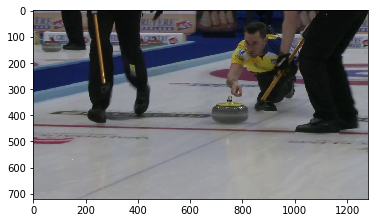

In [45]:
img = mpimg.imread(os.path.join(data_path, 'images/060111501.jpg'))
plt.imshow(img);

In [246]:
transform = torchvision.transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

total_size = len(dataset)
train_size = int(total_size * 0.8)
test_size = total_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [276]:
iter_total = iter(dataset)
total = next(iter_total)
# total = next(iter_total)
# total = next(iter_total)
# total = next(iter_total)
# total = next(iter_total)

# iter_train_dataset = iter(train_dataset)
# sample_train = next(iter_train_dataset)
# sample_train = next(iter_train_dataset)
# sample_train = next(iter_train_dataset)
# sample_train[0]

In [277]:
output = model(total[0].unsqueeze(0))

In [278]:
display(output.shape)
display(output.squeeze()[0])
display(output.squeeze()[0].shape)

torch.Size([1, 16, 64, 64])

tensor([[ 1.9963e-04,  8.0774e-04,  3.1438e-04,  ..., -1.9420e-05,
          7.5814e-05,  1.2120e-03],
        [-3.7757e-04, -1.0344e-04, -6.0539e-05,  ...,  5.4661e-04,
         -1.8856e-04,  6.6216e-04],
        [-2.9911e-04, -2.0427e-04,  1.4010e-05,  ...,  1.4937e-04,
         -4.4528e-05,  1.2532e-04],
        ...,
        [-1.9291e-05, -4.7152e-05, -1.3284e-04,  ...,  1.0931e-03,
          2.0306e-03,  9.5694e-04],
        [-1.9979e-04,  7.2302e-04, -7.1324e-05,  ...,  1.5378e-03,
          1.3616e-03,  1.1082e-03],
        [-7.8251e-04,  1.4295e-04, -1.0312e-04,  ...,  2.5204e-03,
          2.1244e-03,  4.1437e-03]], grad_fn=<SelectBackward>)

torch.Size([64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


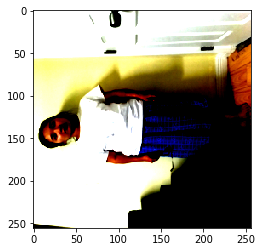

In [279]:
plt.figure()
plt.imshow(total[0].permute(1, 2, 0))

In [280]:
output.squeeze().shape

torch.Size([16, 64, 64])

In [290]:
r_ankle = output.squeeze()[0]

max_ys, each_max_x = r_ankle.max(1)
val, max_y = max_ys.max(0)
display(max_ys, each_max_x)
display(val, max_y)

tensor([0.0012, 0.0008, 0.0008, 0.0009, 0.0011, 0.0031, 0.0011, 0.0071, 0.0039,
        0.0012, 0.0010, 0.0047, 0.0040, 0.0054, 0.0020, 0.0018, 0.0021, 0.0051,
        0.0022, 0.0043, 0.0152, 0.0209, 0.0395, 0.0328, 0.0533, 0.0405, 0.0489,
        0.0262, 0.0193, 0.0080, 0.0109, 0.0283, 0.0261, 0.0126, 0.0095, 0.0088,
        0.0085, 0.0049, 0.0133, 0.0059, 0.0085, 0.0100, 0.0107, 0.0059, 0.0048,
        0.0122, 0.0069, 0.0043, 0.0045, 0.0108, 0.0171, 0.0095, 0.0076, 0.0067,
        0.0114, 0.0052, 0.0039, 0.0016, 0.0019, 0.0023, 0.0016, 0.0020, 0.0015,
        0.0041], grad_fn=<MaxBackward0>)

tensor([63,  7,  4,  7,  7,  6,  5,  4,  3, 59,  5, 30, 30, 52, 25, 57, 55, 58,
        60, 60, 33, 33, 34, 33, 32, 33, 33, 33, 33, 52, 54, 52, 52, 52, 52, 48,
        48, 48, 58, 57, 59, 62, 59, 62, 59, 63, 63, 63, 59, 63, 63, 63, 63, 63,
        63, 62, 62, 63, 62, 62, 47, 62, 61, 63])

tensor(0.0533, grad_fn=<MaxBackward0>)

tensor(24)

In [281]:
xs, ys = [], []
for i in range(len(body_point_names)):
    value, x = output.squeeze()[i].max(1)
    value, y = value.max(0)
    
    xs.append(x[y].item())
    ys.append(y.item())
    
    print (body_point_names[i])
    print(y.item(), x[y].item())

R_ANKLE
24 32
R_KNEE
30 58
R_HIP
35 33
L_HIP
35 30
L_KNEE
29 63
L_ANKLE
38 59
PELVIS
35 32
THORAX
34 15
UPPER_NECK
35 14
HEAD_TOP
37 2
R_WRIST
25 31
R_ELBOW
22 23
R_SHOULDER
27 15
L_SHOULDER
41 16
L_ELBOW
45 24
L_WRIST
45 35


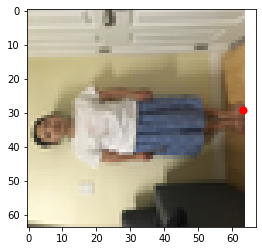

In [295]:
# img64 = total[0].permute(1, 2, 0).detach().numpy()

im = Image.open(os.path.join(data_path, 'images/IMG-8563.jpg'))
im = im.resize((64, 64), Image.ANTIALIAS)

plt.figure()
plt.imshow(im)
plt.scatter(x=xs[4], y=ys[4], color='red', s=50)

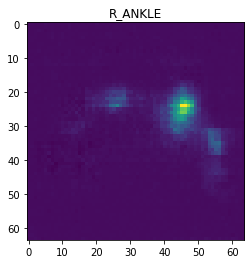

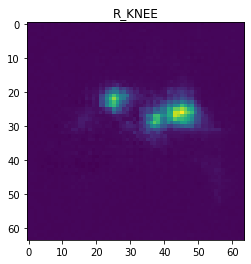

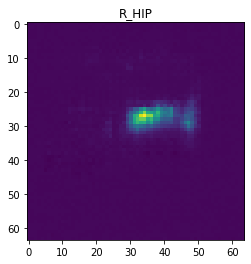

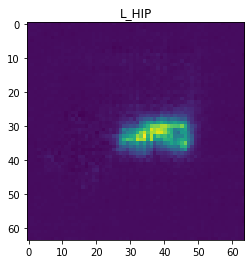

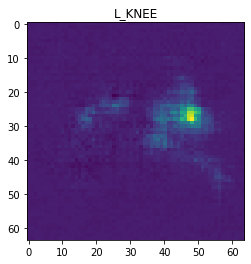

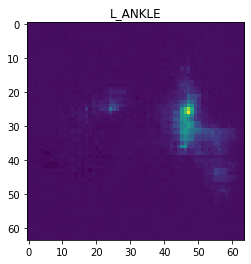

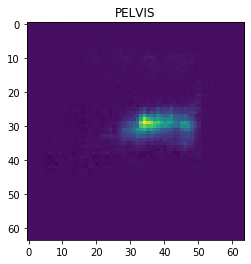

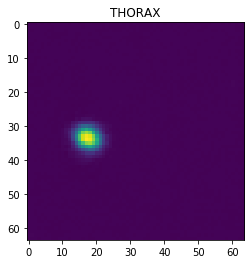

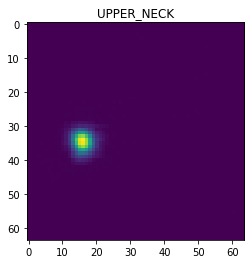

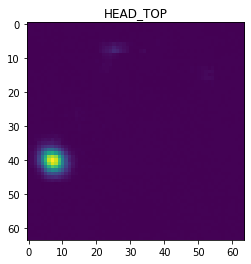

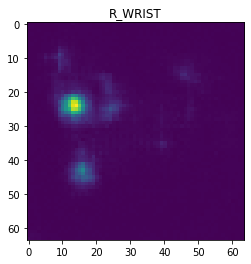

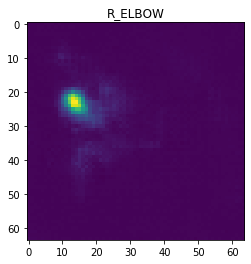

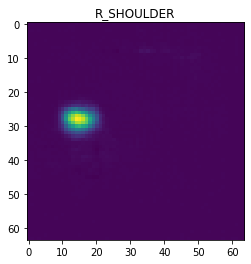

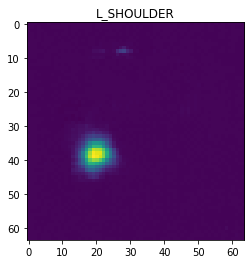

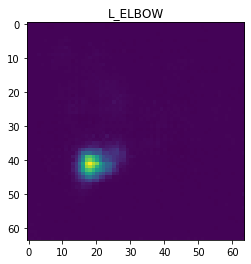

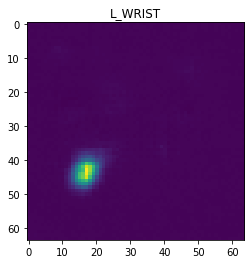

In [240]:


for i in range(16):
    plt.figure()
    plt.title(body_point_names[i])
    plt.imshow(output.squeeze()[i].detach().numpy())
    